In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from pandas.plotting import autocorrelation_plot
import datetime
import warnings
from sklearn.metrics import mean_squared_error
#warnings.filterwarnings('ignore')

#reading the dataset
farmers_df = pd.read_csv("Mock Data.csv",index_col="Farmer No.",thousands=',')
farmers_df.describe()

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Week1,Week2,Week3,Week4,Week5,Week6,Week7,Week8,Week9,Week10,...,Week43,Week44,Week45,Week46,Week47,Week48,Week49,Week50,Week51,Week52
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,...,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,14984.454118,16007.744314,15136.750588,15412.348235,11932.422745,18038.498824,19770.973333,18944.767059,9279.968627,23176.995294,...,13906.559216,10880.016471,9369.428235,8956.124706,9583.287059,11130.280784,13879.662745,14266.894118,10084.778039,15305.047843
std,34427.387470,37055.987637,35325.119529,34375.358243,26475.195702,39944.456090,47577.790608,41383.825336,20859.309558,47749.294955,...,29253.523633,24283.426121,22619.675055,21577.699170,22787.558980,25713.935543,32825.291777,32147.934363,27421.623229,34553.161918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,340.000000,398.500000,447.500000,503.000000,156.000000,470.500000,381.000000,420.500000,0.000000,418.000000,...,622.500000,0.000000,0.000000,0.000000,0.000000,417.000000,1070.500000,1350.500000,645.500000,1433.500000
50%,4213.000000,4070.000000,4155.000000,4040.000000,3137.000000,4910.000000,4931.000000,4846.000000,2024.000000,6279.000000,...,4373.000000,3555.000000,2852.000000,2518.000000,2633.000000,3998.000000,5242.000000,5125.000000,2967.000000,5116.000000
75%,15508.500000,14976.500000,14060.500000,14902.500000,12083.500000,17435.500000,19164.000000,19121.500000,9982.500000,25384.500000,...,16810.500000,12837.500000,10571.500000,9219.000000,10104.500000,11903.500000,14753.500000,14591.500000,9503.500000,15432.000000
max,651762.000000,449877.000000,507413.000000,420506.000000,309626.000000,527924.000000,668722.000000,623627.000000,336218.000000,667226.000000,...,547147.000000,554049.000000,549871.000000,529063.000000,534634.000000,506125.000000,517352.000000,524823.000000,516755.000000,518525.000000


###  Calculating number of missing weeks and dropping farmers with more than 20% of the weeks missing

In [2]:
farmers_df['Missing Weeks'] = farmers_df.apply( lambda s : s.value_counts().get(0,0), axis=1)
farmer_filtered_df = farmers_df[farmers_df['Missing Weeks'] < np.round(52*.20)].copy()
farmer_filtered_df.drop(['Missing Weeks'], inplace=True, axis=1)

###  Plotting data to check if any trend

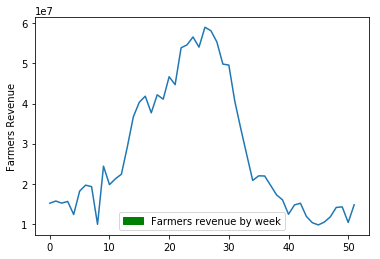

In [4]:
plt.plot(farmer_filtered_df.sum(axis=0).values)


plt.ylabel('Farmers Revenue')
green_patch = mpatches.Patch(color='green', label='Farmers revenue by week')
plt.legend(handles=[green_patch])
import matplotlib.pyplot as plt

plt.show()

###  Plotting distribution of data which is right skewed

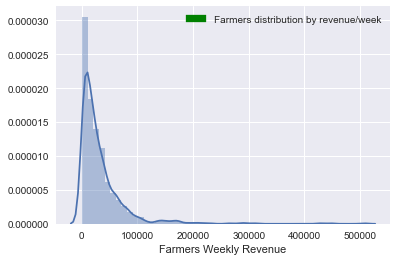

In [5]:
sns.set(color_codes=True)
farmers_weekly_revenue = farmer_filtered_df.sum(axis=1)/52
green_patch = mpatches.Patch(color='green', label='Farmers distribution by revenue/week')
plt.legend(handles=[green_patch])
sns.distplot(farmers_weekly_revenue)

_ = plt.xlabel('Farmers Weekly Revenue')

plt.show()

###  Plotting ECDF to check the proportions and numbers

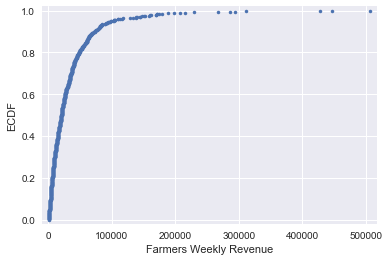

In [6]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1,n+1) / n
    return x, y

farm_x, farm_y = ecdf(farmers_weekly_revenue)

_ = plt.plot(farm_x, farm_y, linestyle='none', marker = '.')
_ = plt.margins(0.02)
_ = plt.xlabel('Farmers Weekly Revenue')
_ = plt.ylabel('ECDF')

plt.show()

###  Generating dates required for Model

In [8]:
dates = []
for week in range(1,53):
    week = "2017-W"+str(week)
    dates.append(datetime.datetime.strptime(week + '-0', "%Y-W%W-%w").date())

###  Function evaluation model's performance using mean squared error

In [9]:
def evaluate_arima_model(train_X,test_X, arima_order):
    # prepare training dataset
    history = np.log(np.array([val for index,val in train_X.iteritems()])+1).tolist()
    test = np.log(np.array([val for index,val in test_X.iteritems()])+1).tolist()
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # fit model
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=False)
        # one step forecast
        yhat = model_fit.forecast()[0]
        # store forecast and ob
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

###  Performing Grid Search 

In [10]:
def evaluate_models(train_ds,test_ds, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(train_ds,test_ds, order)
                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

###  Optimizing for all the time series using Gridsearch for the values of p,d,q

In [13]:
def optimize_arima_hyperparams():
    train_series = pd.Series()
    test_series = pd.Series()
    train_size = int(np.round(.75*len(farmer_filtered_df.columns)))
    p_values = [0, 1, 2, 4,5]
    d_values = range(0, 3)
    q_values = range(0, 6)
    warnings.filterwarnings("ignore")
    orders= {}
    i = 0
    for index, row in farmer_filtered_df.iterrows():
        train_series = pd.Series(np.array(row[farmer_filtered_df.columns[:train_size].values].values, dtype=float), index=dates[:train_size])
        test_series = pd.Series(np.array(row[farmer_filtered_df.columns[train_size:]].values, dtype=float), index=dates[train_size:])
        i = i + 1
        print(i)
        orders[str(index)] = evaluate_models(train_series,test_series, p_values, d_values, q_values)
    print(orders)

###  Loading optimized params and best error values from pickle files

In [12]:
import pickle
orders= pickle.load(open("orders.pkl", "rb"))
errors= pickle.load(open("errors.pkl", "rb"))

###  Forecasting for each time series

In [105]:
def forecast_next_13_weeks(historical_data, arima_order):
    # make predictions
    predictions = list()
    model = ARIMA(historical_data, order=arima_order)
    model_fit = model.fit(disp=False)
    if(arima_order[1] != 0):
        predictions = model_fit.predict(52, 64, typ='levels')
    else:
        predictions = model_fit.predict(52, 64)
    return list(predictions)

In [131]:
forecasted_revenues = pd.DataFrame(columns=['forecasted_week'+str(x) for x in range(1,14)]+['Farmer No.','Error'])
for index, row in farmer_filtered_df.iterrows():
    order = (orders[str(index)]['p'],orders[str(index)]['d'],orders[str(index)]['q'])
    farmer_row = np.log(np.array([float(val) for val in row.values])+1)
    warnings.filterwarnings('ignore')
    try:
        predictions = np.exp(forecast_next_13_weeks(farmer_row,order))
        forecastVal = [pred for pred in predictions] + [index,np.exp(errors[str(index)])]
        forecasted_revenues.loc[len(forecasted_revenues)] = forecastVal
    except:
        continue

In [132]:
forecasted_revenues.set_index('Farmer No.', inplace=True)

In [133]:
final_farmers_df = pd.merge(farmer_filtered_df, forecasted_revenues, left_index=True, right_index=True, how='inner')

In [247]:
final_farmers_df['Missing Weeks'] = final_farmers_df[final_farmers_df.columns[:52]].apply( lambda s : s.value_counts().get(0,0), axis=1)

In [248]:
final_farmers_df['Error'] = final_farmers_df['Error'].round()

###  Calculating Rating Scores

In [249]:
def calculate_rating_scores(farmer_val,base):
    return base/farmer_val
final_farmers_df['Certainity Score'] = [calculate_rating_scores(row['Error'],0.4) for index, row in final_farmers_df.iterrows()]
final_farmers_df['Novelity Score'] = [calculate_rating_scores(row['Missing Weeks']+1,0.2) for index, row in final_farmers_df.iterrows()]
final_farmers_df['Mean Forecasted Revenue'] = final_farmers_df[final_farmers_df.columns[52:65]].mean(axis=1)

In [250]:
ninty_percentile = np.percentile(final_farmers_df['Mean Forecasted Revenue'],90)
final_farmers_df['Value Score'] = 0.0
final_farmers_df['Value Score'] = final_farmers_df['Mean Forecasted Revenue'] > ninty_percentile

In [251]:
timeseries = np.arange(0,13,1)    
final_farmers_df['Stability Trend Score']  = [np.corrcoef(x,timeseries)[0][1]*.3 for x in final_farmers_df[final_farmers_df.columns[52:65]].values]
final_farmers_df['Farmer Rating'] = final_farmers_df[['Stability Trend Score','Certainity Score','Novelity Score','Value Score']].sum(axis=1) 

In [252]:
final_farmers_df['Eligibility'] = False
final_farmers_df['Eligibility']  = final_farmers_df['Farmer Rating'] >= .5

###  Calculating loan amounts for eligible farmers

In [255]:
def calculate_loan_amt(farmer_revenue):
    loan = 0.0
    if farmer_revenue >= np.percentile(final_farmers_df['Mean Forecasted Revenue'],90):
            loan = np.round(farmer_revenue*.35*13)
    elif farmer_revenue >= np.percentile(final_farmers_df['Mean Forecasted Revenue'],50):
            loan = np.round(farmer_revenue*.30*13)
    else:
            loan = np.round(farmer_revenue*.20*13)
    return loan

In [260]:
loans = []
for index, row in final_farmers_df.iterrows():
    if(row['Eligibility'] == True):
          loans.append(calculate_loan_amt(row['Mean Forecasted Revenue']))
    else:
        loans.append(0.0)
final_farmers_df['Loan Amt.'] = loans

In [261]:
final_farmers_df.to_csv('Results.csv')